# GHZ State Correction

In this notebook, I will provide a code to correct GHZ state with different response matrix, and compare the performance of different error mitigation method. 

## I. Introduction of Background Knowledge
In this section, I will introduce GHZ state and the fidelity. 
### A. The GHZ State
To evaluate the performance of various measurement error mitigation method, we need to compare the mitigation result of different methods with given ideal state. One of commonly used quantum state in quantum computation is the Greenberger–Horne–Zeilinger state (GHZ state). GHZ state was firstly designed for a 3 qubits case, and we can generalize the GHZ state to any $n\geq 2$ case as
\begin{equation}
|{\rm GHZ}\rangle = \frac{|0\rangle^{\otimes n} +|1\rangle^{\otimes n} }{\sqrt{2}}
\end{equation}
As an example, I will evaluate the performance of different mitigation method using the ideal $n=5$ GHZ state
\begin{equation}
|{\rm GHZ}\rangle = \frac{|00000\rangle +|11111\rangle }{\sqrt{2}}
\end{equation}


### B. The Fidelity
The fidelity is used to measure the difference of two quantum state $\rho = |\psi\rangle\langle\psi|$ and $\sigma = |\phi\rangle\langle\phi|$, 
\begin{equation}
F(\rho, \sigma) = {\rm tr}\left(\sqrt{\rho^{1/2}\sigma\rho^{1/2}}\right)
\end{equation}
Note that $0\leq F\leq 1$, $F = 1$ if $\rho=\sigma$ and $F=0$ if $\langle \psi|\phi\rangle = 0$. For a pure state $|\psi\rangle$ and arbitrary state $\sigma$, the fidelity can be re-written as
\begin{equation}
F(|\psi\rangle, \sigma) = \sqrt{\langle\psi|\sigma|\psi\rangle}
\end{equation}

Below I define a function `fidelity` to get the fidelity between 5-qubit GHZ state and the correction state. Note that function `fidelity` bases on the definition for pure state $|\psi\rangle$. 

In [1]:
# Import require package
import numpy as np
from qiskit import QuantumCircuit, transpile, IBMQ, assemble
from qiskit.providers.ibmq.job import job_monitor

# Load the IBMQ backend
provider = IBMQ.load_account()
backend = provider.backend.ibmq_lima

In [2]:
def fidelity(psi, sigma):
    # Make sure psi is a column vector
    try: 
        if psi.shape[1] != 1:
            return np.nan
    except IndexError:
        return np.nan
    
    psi_dagger = np.conjugate(psi).T
    # Make sure output is a number
    return np.sqrt(np.matmul(psi_dagger, np.matmul(sigma, psi)))[0,0]

As an example, I will use the $n=5$ GHZ state obtained from IBM Q superconducting processor **ibmq_lima** and perform the correction on it. For the whole process of using qiskit to perform correction, we need to

* Get GHZ raw data
* Prepare different response matrix
* Run the correction and get new data
* Evaluate the score of correction

In the following sections, I will provide details of how to correct noisy data and get the evaluation of performance.

## II. Run Correction
In this section, I will describe details of how to run correction with given response matrix and noisy data. 

### A. Get GHZ Data
To get the GHZ state for $n=5$ qubits, we need to construct the following circuit and run it on the **ibmq_lima** processor. 

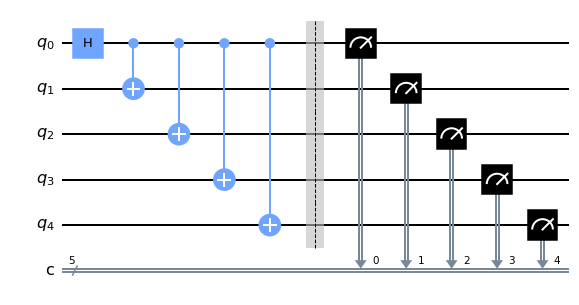

In [3]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit

qreg_q = QuantumRegister(5, 'q')
creg_c = ClassicalRegister(5, 'c')
circuit = QuantumCircuit(qreg_q, creg_c)

circuit.h(qreg_q[0])
circuit.cx(qreg_q[0], qreg_q[1])
circuit.cx(qreg_q[0], qreg_q[2])
circuit.cx(qreg_q[0], qreg_q[3])
circuit.cx(qreg_q[0], qreg_q[4])
circuit.barrier()
circuit.measure(qreg_q[0], creg_c[0])
circuit.measure(qreg_q[1], creg_c[1])
circuit.measure(qreg_q[2], creg_c[2])
circuit.measure(qreg_q[3], creg_c[3])
circuit.measure(qreg_q[4], creg_c[4])
circuit.draw()

After running the circuit, we can get data from the job ID as follow. Note that the output from quantum device is a dictionary, but we need to convert it into an array with the order as the output of `basis_state` function. Below I 

In [4]:
def get_basis_state(nqubit):
    if nqubit <= 0:
        print("nqubit should be greater than 0")
        return 0
    
    if nqubit > 1:
        tmp1 = ['0' + i for i in get_basis_state(nqubit-1)]
        tmp2 = ['1' + i for i in get_basis_state(nqubit-1)]
        return tmp1 + tmp2
    if nqubit == 1:
        return ['0', '1']

In [5]:
def get_data(raw, nqubit):
    """
    Make sure the raw data is in the order of basis state
    """
    basis_state = get_basis_state(nqubit)
    size = 2**nqubit
    data = np.zeros(size) * np.nan
    for i in range(size): 
        state = basis_state[i]
        try: 
            data[i] = raw[state]
        except KeyError:
            data[i] = 0
    
    return data/np.sum(data)

In [6]:
# Be careful of the order of data
job_id = '61f8c970ad876ad08263ab73'
raw = backend.retrieve_job(job_id).result().get_counts()
data = get_data(raw, 5)
data

array([0.4037 , 0.00615, 0.0198 , 0.00175, 0.01625, 0.0012 , 0.0069 ,
       0.0042 , 0.01245, 0.0028 , 0.0012 , 0.0026 , 0.0053 , 0.0061 ,
       0.0074 , 0.01745, 0.00575, 0.0053 , 0.00075, 0.00505, 0.0008 ,
       0.00665, 0.00085, 0.0204 , 0.0048 , 0.0141 , 0.00155, 0.0277 ,
       0.0037 , 0.09855, 0.0116 , 0.2772 ])

### B. Prepare Response Matrix
The response matrices are obtained in different ways as mentioned in the `../response` directory. We don't need to care about how to generate the response matrices here, but only load the `.txt` files and use the data directly. Here we will test the following response matrices:

* **No.1:** Classical response matrix from classical calibration experiment (`../response/classical-response.ipynb`)
* **No.2:** Scalable classical response matrix (use data in Hamming distance as 1) (`../response/simple-scalable.ipynb`)
* **No.3:** Classical response matrix obtained from tensor product (`../response/simple-tensor.ipynb`)
* **No.4:** Gamma matrix obtained from tensor product (`../response/gamma-matrix.ipynb`)
* **No.5:** Scalable gamma matrix (use data in Hamming distance as 1) (`../response/simple-scalable.ipynb`)

Below I will load data from the `.txt` files with corresponding response matrix number. 

In [7]:
res1 = np.loadtxt('./result/classical-response.txt')
res2 = np.loadtxt('./result/scalable-A.txt')
res3 = np.loadtxt('./result/simple-tensor.txt')
res4 = np.loadtxt('./result/gamma.txt')
res5 = np.loadtxt('./result/scalable-gamma.txt')

### C. Run the Correction
In the directory `../correction`, I include three noisy data unfolding methods that are widely used in current stage: inverse matrix, least square and iterative Bayesian unfolding. Here I simply copy-paste the code there and I will use all three methods to correct the noisy data and check the performance. 

In [8]:
# Inverse matrix unfolding
import scipy.linalg as la

def pseudoInverse(initialA, rawData):
    """
    Following IBM Qiskit, we define a function to compute the 
    (Moore-Penrose) pseudo-inverse of a matrix as calibration.
    """
    calMatrix = la.pinv(initialA)
    return np.matmul(calMatrix, rawData)

In [9]:
# Least Square unfolding
from scipy.optimize import minimize
def leastQ(initialA, rawData):
    """
    Following IBM Qiskit, we define a function to compute the calibration
    by minimizing ||Lambda * Count_est - Count_exp||_2. Make sure input 
    parameters should be probability
    
    Use function in this way: 
    leastQ(resMatrix/size, data/sum(data))
    """
    # Make sure the element of A is probability 
    #if np.sum(initialA) > 1:
    #    for i, _ in enumerate(initialA):
    #        initialA[i] = initialA[i]/np.sum(initialA[i])
    
    # Make sure the element of data is probability 
    #if np.sum(rawData) > 1:
    #    rawData = rawData/np.sum(rawData)
    
    realData = np.copy(rawData) # Deep copy
    
    # Define the function need to be minimized, x is the estimated true value
    def fun(x):
        return sum((rawData - np.dot(initialA, x))**2)
    
    x0 = np.random.rand(len(rawData)) # Generate random initial fitting value
    x0 = x0 / sum(x0) # Normalized the initial value
    
    cons = ({'type': 'eq', 'fun': lambda x: sum(x) - 1}) # Make sure the sum of probability is 
    bnds = tuple((0, 1) for x in x0) # Make sure probability is between 0 and 1
    mitigation = minimize(fun, x0, method='SLSQP', constraints=cons, bounds=bnds, tol=1e-6)
    
    return mitigation.x

In [10]:
# Iterative Bayesian unfolding
def IBU(initialA, rawData, nIter):
    """
    Following public code of nature paper, we define a function to compute the calibration
    by iterative Bayesian unfolding method. Make sure input parameters should be probability
    
    Use function in this way: 
    IBU(resMatrix/4096, data1/sum(data1),10)
    """
    dataLen = len(rawData)
    t0 = np.ones(dataLen)
    tn = t0
    
    for k in range(nIter):
        # for k-th iteration time
        tmp = np.ones(dataLen) # define the t_n+1 null array
        
        # for each element in the array
        for i in range(dataLen): 
            jSum = 0 # initial the sum
            for j in range(dataLen):
                tmpSum = np.dot(initialA[j], tn) # Get sum of R_jk*t_k^n as inner product
                jSum += initialA[j][i] * tn[i] * rawData[j] / tmpSum # sum up R_ji * t_i^n * m_j for j 
            
            tmp[i] = np.copy(jSum)

        tn = np.copy(tmp) # return the result after k-th iteration 
    return tn

Below I will run three unfolding methods and get mitigation result corresponding to the given $5$ response matrices. Note that the result data are corrected probability of getting certain basis state. 

In [11]:
result = {}
response = {'res1':res1, 'res2':res2, 'res3':res3, 'res4':res4, 'res5':res5}
for i in ['res1', 'res2', 'res3', 'res4', 'res5']:
    tmp_res = response[i]
    tmp_inv = pseudoInverse(tmp_res, data)
    tmp_leq = leastQ(tmp_res, data)
    tmp_ibu = IBU(tmp_res, data, nIter = 10)
    result[i] = {'inv': tmp_inv, 'leq': tmp_leq, 'ibu': tmp_ibu}

In [12]:
result

{'res1': {'inv': array([ 4.21059954e-01,  1.54536981e-03,  1.75826546e-02,  6.28547097e-04,
          1.44282019e-02,  2.97260250e-04,  7.42249442e-03,  2.96290429e-03,
          5.36565054e-03,  1.55041505e-03,  4.49152564e-05,  1.39270737e-03,
          5.43446195e-03, -8.33401949e-03,  8.19205708e-03, -2.92906209e-02,
          1.83414665e-03,  5.28518351e-03,  4.84275164e-04,  3.86240376e-03,
          5.38374200e-04,  2.49705788e-03, -1.96540980e-04,  1.07465301e-02,
          5.14450425e-03,  4.01693454e-03,  6.48741787e-04, -3.99879520e-03,
         -1.29243895e-03,  1.21024158e-01, -2.29850227e-03,  4.01421014e-01]),
  'leq': array([4.20180038e-01, 0.00000000e+00, 1.64757445e-02, 0.00000000e+00,
         1.26984783e-02, 0.00000000e+00, 6.02012476e-03, 1.00627514e-17,
         4.42491466e-03, 1.71439469e-18, 7.79270311e-19, 3.17806762e-18,
         3.39493075e-03, 9.24959978e-18, 4.62354219e-03, 0.00000000e+00,
         2.12785055e-04, 3.57825298e-03, 0.00000000e+00, 1.88312077e

### D. Evaluate the performace
Here I will use the fidelity to measure the difference between the mitigated state $|\psi\rangle$ and the ideal state $|\phi\rangle = |{\rm GHZ}\rangle$. The density matrix of state $|\phi\rangle$ is given by $\sigma = |{\rm GHZ}\rangle\langle {\rm GHZ}|$. Here I calculate $\sigma$ below. 

In [13]:
import numpy as np
nqubit = 5
phi = np.ones((2**nqubit, 1)) * 0 # This should be a n*1 matrix, or column matrix, or shape (2**n, 1)
phi[0] = (1/np.sqrt(2))
phi[-1] = (1/np.sqrt(2))
phi_dagger = np.conjugate(phi).T # This should be a 1*n matrix, or row matrix, or shape (1, 2**n)
sigma = np.matmul(phi, phi_dagger)
sigma

array([[0.5, 0. , 0. , ..., 0. , 0. , 0.5],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       ...,
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0.5, 0. , 0. , ..., 0. , 0. , 0.5]])

Note that the mitigated result are in probability, and we need to add a square root to make sure they are in the form of 
\begin{equation}
|\psi\rangle = \sum c_{i}|i\rangle = \sum \sqrt{p_{i}}|i\rangle
\end{equation}
(I don't use this here) Below I define `func` to convert the given mitigated probability into complex form, which is convenient to get the $c_i$ from $\sqrt{p_i}$ if mitigated $p_i$ is negative (especially for inverse matrix). 

In [14]:
score = {}
#func = lambda i:complex(i)
for i in ['res1', 'res2', 'res3', 'res4', 'res5']:
    tmp_score = {}
    for j in ['leq', 'ibu']: # ['inv', 'leq', 'ibu']
        tmp = np.array([result[i][j]]).T
        #psi = np.sqrt(np.array(list(map(func, result[i][j]))))
        psi = np.sqrt(tmp)   # use this if probability are all non-negative
        tmp_score[j] = fidelity(psi, sigma)
        
    score[i] = tmp_score

Recall here we have five response with number:
* **No.1:** Classical response matrix
* **No.2:** Scalable classical response matrix
* **No.3:** Classical response matrix obtained from tensor product
* **No.4:** Gamma matrix obtained from tensor product (`../response/gamma-matrix.ipynb`)
* **No.5:** Scalable gamma matrix

In [15]:
score

{'res1': {'leq': 0.9018906593570427, 'ibu': 0.8852882412194392},
 'res2': {'leq': 0.8929803969365567, 'ibu': 0.8768776552601821},
 'res3': {'leq': 0.8835071870182769, 'ibu': 0.8724122999955259},
 'res4': {'leq': 0.9150430773269651, 'ibu': 0.8923716114997946},
 'res5': {'leq': 0.9035594372314838, 'ibu': 0.8840430007871095}}